In [4]:
from flowjax.train.data_fit import fit_to_data
from flowjax.train.losses import ContrastiveLoss
from flowjax.flows import masked_autoregressive_flow as MaskedAutoregressiveFlow
from flowjax.distributions import Normal, Laplace
import flowjax.bijections as bij
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import equinox as eqx
import numpy as np
from sklearn.preprocessing import StandardScaler
from jax import vmap
import pandas as pd
import json
import pickle

In [5]:
#observed data
filename = "./observed_stats.csv"
x_o = pd.read_csv(filename)
#simulated data
filename2 = "./summary_stats_r1.csv"
x = pd.read_csv(filename2)
#params for simulations
filename3 = "./thetas_r1.csv"
theta = jnp.array(np.genfromtxt(filename3, delimiter=',', dtype=float))

In [6]:
to_drop = [#correlation >0.99
    "y1_domestic",
    "y1_scot",
    "y1_captive",
    "y1_eu",
    "y1_lyb",
    "y3_domestic_captive_lyb",
    "divergence_domestic_eu",
    "y3_domestic_scot_lyb",
    "y3_domestic_eu_lyb",
    "divergence_captive_lyb",
    "segregating_sites_lyb",
    "segregating_sites_eu",
    "divergence_scot_lyb",
    "f4_domestic_scot_captive_lyb",
    "f4_domestic_captive_eu_lyb",
    "f4_domestic_scot_eu_lyb",
    "diversity_domestic",
    "y3_domestic_scot_captive",
    "y3_scot_captive_eu",
    "f2_domestic_eu",
    "y2_domestic_lyb",
    "y3_scot_captive_lyb",
    "divergence_captive_eu",
    "pc1_dist_domestic_eu"]

In [3]:
to_drop = [#correlation >0.99
    "y1_domestic",
    "y1_scot",
    "y1_captive",
    "y1_eu",
    "y1_lyb",
    "y3_domestic_captive_lyb",
    "divergence_domestic_eu",
    "y3_domestic_scot_lyb",
    "y3_domestic_eu_lyb",
    "divergence_captive_lyb",
    "segregating_sites_lyb",
    "segregating_sites_eu",
    "divergence_scot_lyb",
    "f4_domestic_scot_captive_lyb",
    "f4_domestic_captive_eu_lyb",
    "f4_domestic_scot_eu_lyb",
    "diversity_domestic",
    "y3_domestic_scot_captive",
    "y3_scot_captive_eu",
    "f2_domestic_eu",
    "y2_domestic_lyb",
    "y3_scot_captive_lyb",
    "divergence_captive_eu",
    "pc1_dist_domestic_eu",
    # outlier noise model method r1 (>1)
    'tajimas_d_eu',
    'relatedness_domestic_lyb',
    'pc1_iqr_domestic',
    'pc1_iqr_eu',
    'pc1_iqr_lyb',
    'pc2_iqr_domestic',
    'pc2_iqr_lyb',
    # outlier noise model method r2 (>0.8)
    'relatedness_captive_lyb',
    'pc1_median_eu',
    'pc2_dist_domestic_lyb']

{'tajimas_d_eu': 2.924356698989868,
 'relatedness_domestic_lyb': 1.0065529346466064,
 'pc1_median_eu': 0.8109098672866821,
 'pc2_median_lyb': 0.8232396245002747,
 'pc1_iqr_domestic': 2.226839542388916,
 'pc1_iqr_eu': 5.434721946716309,
 'pc1_iqr_lyb': 2.033045768737793,
 'pc2_iqr_domestic': 2.554408073425293,
 'pc2_iqr_lyb': 9.832843780517578}

{'tajimas_d_eu': 2.9451754093170166,
 'relatedness_domestic_lyb': 1.0059717893600464,
 'pc1_median_eu': 0.8189070820808411,
 'pc2_median_lyb': 0.8371109962463379,
 'pc1_iqr_domestic': 2.2041139602661133,
 'pc1_iqr_eu': 5.41973352432251,
 'pc1_iqr_lyb': 1.970677137374878,
 'pc2_iqr_domestic': 2.5619406700134277,
 'pc2_iqr_lyb': 9.789983749389648}

In [7]:
combined_x = pd.concat([x, x_o], ignore_index=True)
combined_x = combined_x.drop(columns=to_drop)
stats = combined_x.columns
combined_x = combined_x.to_numpy(dtype=np.float32)
np.shape(combined_x)

(10001, 111)

In [8]:
#normalise data
x_scaler = StandardScaler()
print("combined_x shape", np.shape(combined_x))
combined_x_t = x_scaler.fit_transform(combined_x)
x_t = np.float32(combined_x_t[0:10000])
x_o_t = np.float32(combined_x_t[10000])
x_o_t = np.reshape(x_o_t, (1,-1))
print("x_t shape", np.shape(x_t))
print("x_o_t shape", np.shape(x_o_t))

combined_x shape (10001, 111)
x_t shape (10000, 111)
x_o_t shape (1, 111)


In [9]:
theta = theta[1:10001]
log_theta = jnp.log(theta)
theta_scaler = StandardScaler()
theta_t = theta_scaler.fit_transform(log_theta)
print("theta_t shape", np.shape(theta_t))

theta_t shape (10000, 16)


In [33]:
key, subkey = jr.split(jr.PRNGKey(2))
#define prior
n_summaries = 111

unbounded_prior = Normal(jnp.zeros((n_summaries,)))

In [11]:
flow = MaskedAutoregressiveFlow(
    subkey,
    base_dist=Normal(jnp.zeros((n_summaries,))),
)

In [13]:
import optax
optimizer = optax.chain(
        optax.clip_by_global_norm(1),
        optax.adam(5e-4),
    )

In [34]:

fitted_flow, losses_r = fit_to_data(
    key=subkey,
    dist=flow,
    x=x_t,
    optimizer = optimizer,
    max_epochs=1500,
    batch_size = 50,
    max_patience = 20
)

 17%|█▋        | 262/1500 [05:13<24:42,  1.20s/it, train=-272.49313, val=-259.51364 (Max patience reached)]


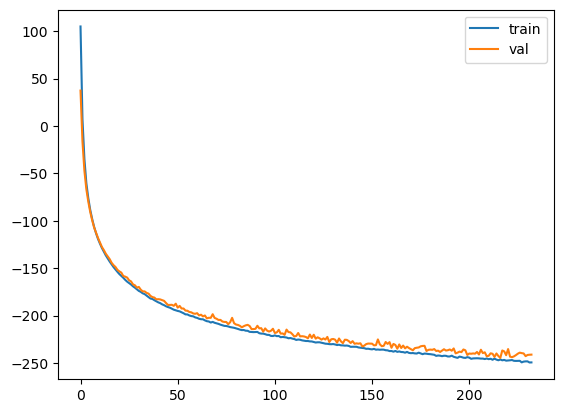

In [26]:
for k, v in losses_r.items():
    plt.plot(v, label=k)
plt.legend()

In [27]:
posterior = fitted_flow
posterior.log_prob(x_o_t)

Array([-3210.4724], dtype=float32)

In [ ]:
Array([-2893.844], dtype=float32)

In [ ]:
Array([-6476.0303], dtype=float32)

#### Stat + error method

In [28]:
from flowjax.experimental.numpyro import sample


def model(obs=None):  # This is a numpyro probabilistic program
    noise_prior = Laplace(jnp.zeros((n_summaries, )), 1)
    error = sample("noise", noise_prior)
    denoised_obs = obs - error
    sample("x", flow, obs=denoised_obs)

In [29]:
from numpyro.infer import MCMC, NUTS
mcmc = MCMC(NUTS(model), num_warmup=1000, num_samples=5000)
key, subkey = jr.split(key)
mcmc.run(subkey, obs=x_o_t)

sample: 100%|██████████| 6000/6000 [02:47<00:00, 35.78it/s, 31 steps of size 1.04e-01. acc. prob=0.84]


([], [])

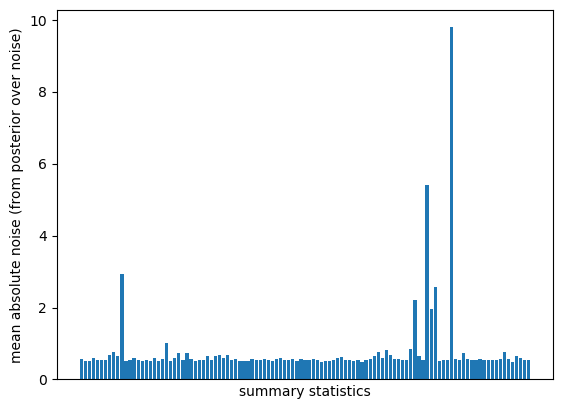

In [30]:
inferred_errors = mcmc.get_samples()["noise"]

mean_abs_error = jnp.abs(inferred_errors).mean(axis=0)
plt.bar(x=[f"s{i}" for i in range(n_summaries)], height=mean_abs_error)
plt.ylabel("mean absolute noise (from posterior over noise)")
plt.xlabel("summary statistics")
plt.xticks([])

In [31]:
error = mean_abs_error.tolist()
error_dict = dict(zip(stats, error))

In [32]:
misspecified = {k: v for k, v in error_dict.items() if v > 0.8
               }
misspecified

{'tajimas_d_eu': 2.9451754093170166,
 'relatedness_domestic_lyb': 1.0059717893600464,
 'pc1_median_eu': 0.8189070820808411,
 'pc2_median_lyb': 0.8371109962463379,
 'pc1_iqr_domestic': 2.2041139602661133,
 'pc1_iqr_eu': 5.41973352432251,
 'pc1_iqr_lyb': 1.970677137374878,
 'pc2_iqr_domestic': 2.5619406700134277,
 'pc2_iqr_lyb': 9.789983749389648}

In [43]:
misspecified.keys()

dict_keys(['relatedness_captive_lyb', 'pc1_median_eu', 'pc2_dist_domestic_lyb'])

In [ ]:
{'tajimas_d_eu': 2.924356698989868,
 'relatedness_domestic_lyb': 1.0065529346466064,
 'pc1_iqr_domestic': 2.226839542388916,
 'pc1_iqr_eu': 5.434721946716309,
 'pc1_iqr_lyb': 2.033045768737793,
 'pc2_iqr_domestic': 2.554408073425293,
 'pc2_iqr_lyb': 9.832843780517578}

In [ ]:
# iter 1.1 (1)
{'tajimas_d_eu': 2.7469213008880615,
 'pc1_iqr_domestic': 2.56209135055542,
 'pc1_iqr_eu': 4.763359069824219,
 'pc1_iqr_lyb': 2.1821603775024414,
 'pc2_iqr_domestic': 2.159055709838867,
 'pc2_iqr_lyb': 9.031184196472168}

In [ ]:
# iter 1.2 (0.7)
{'relatedness_domestic_lyb': 0.823789656162262,
 'fst_domestic_lyb': 0.8101553320884705}

In [ ]:
# iter 1
{'relatedness_captive_lyb': 1.1016290187835693,
 'fst_scot_lyb': 1.277429461479187,
 'pc2_dist_domestic_lyb': 1.1340640783309937,
 'pc2_dist_scot_lyb': 1.3770017623901367}

In [ ]:
# iter 2
{'relatedness_scot_lyb': 1.4759607315063477}

In [ ]:
misspecified_stats
 
pc1_iqr_domestic
pc1_iqr_eu
pc1_iqr_lyb
pc2_iqr_domestic
pc2_iqr_lyb


In [22]:
# save proposal between rounds
model = proposal

with open("./posterior_r1.eqx", "wb") as f:
    eqx.tree_serialise_leaves(f, model)

In [23]:
# save sample parameters for next round
posterior = proposal
samples = posterior.sample(subkey, (10000,), condition=x_o_t)
samples = np.reshape(samples, (10000,16))
samples = theta_scaler.inverse_transform(samples)
theta_2 = np.exp(samples)
#tr2 = pd.DataFrame(theta_2)
#tr2.to_csv("tr2_jax.csv", index=False)

In [24]:
#parameter names for plots
names = ["captive_time",
        "div_time",
        "div_time_dom",
        "div_time_scot",
        "mig_rate_captive",
        "mig_rate_scot",
        "mig_length_scot",
        "pop_size_captive",
        "pop_size_domestic_1",
        "pop_size_lyb_1",
        "pop_size_lyb_2",
        "pop_size_scot_1",
        "pop_size_eu_1",
        "pop_size_eu_2",
        "mutation_rate",
        "recombination_rate"
        ]

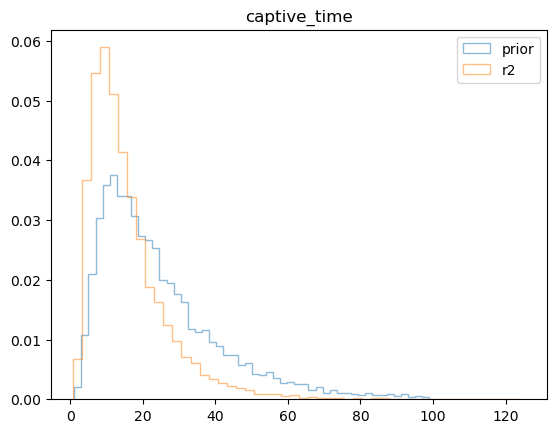

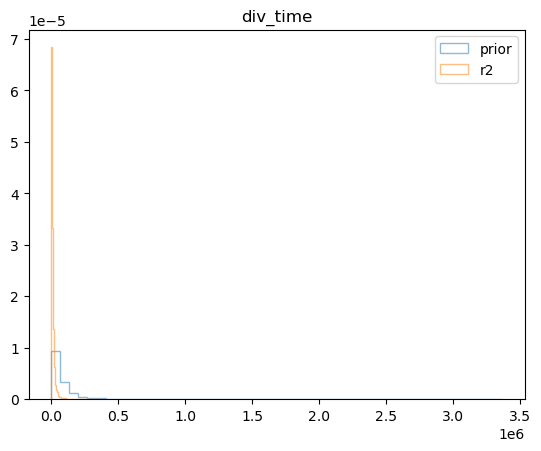

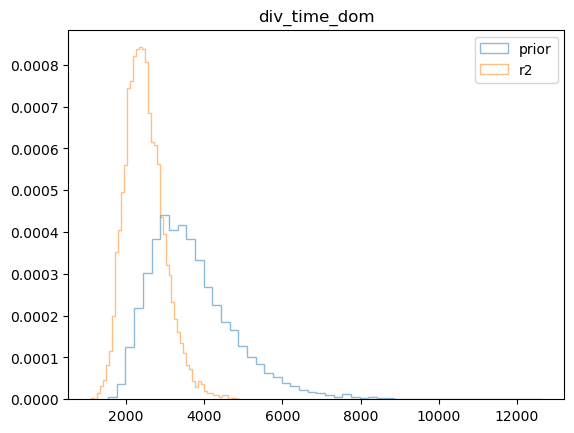

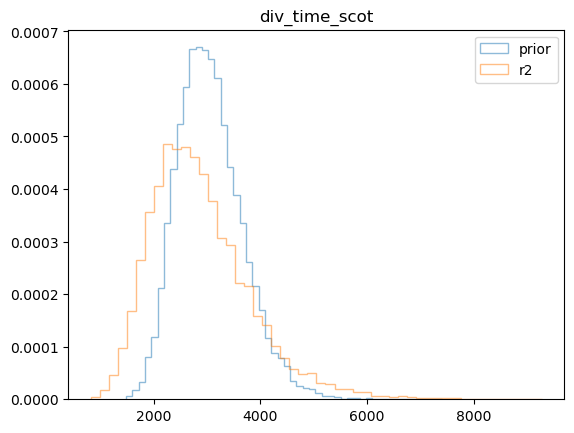

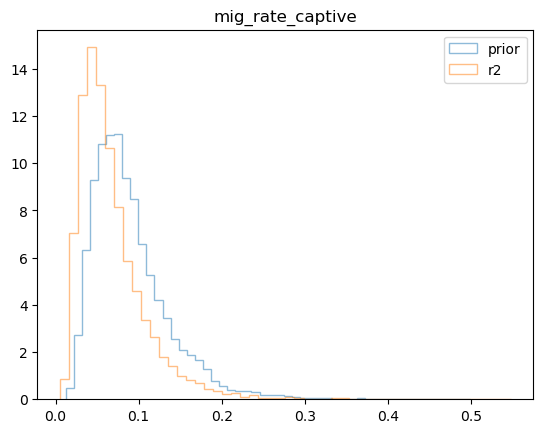

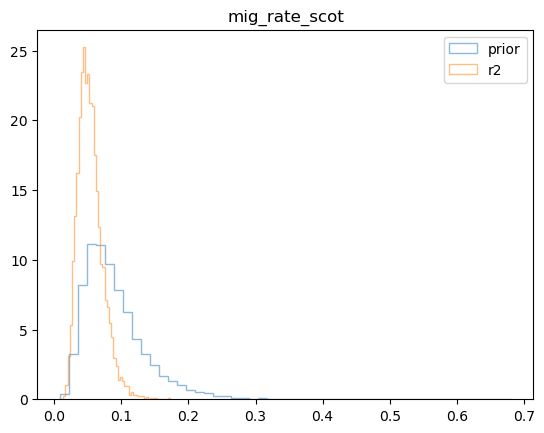

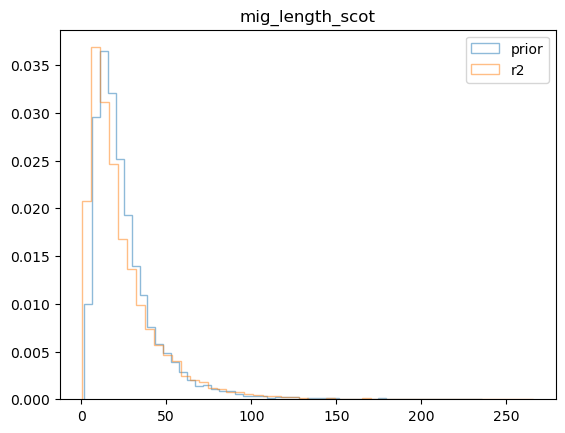

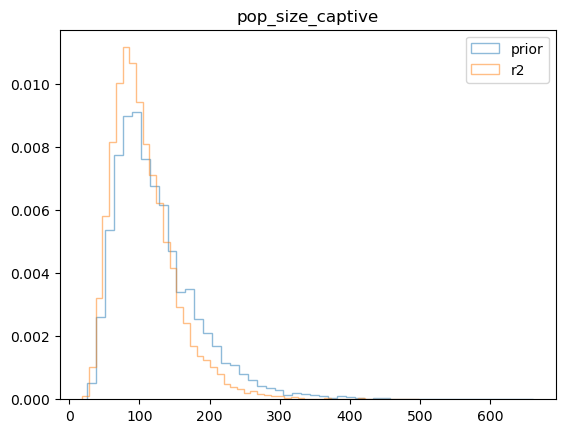

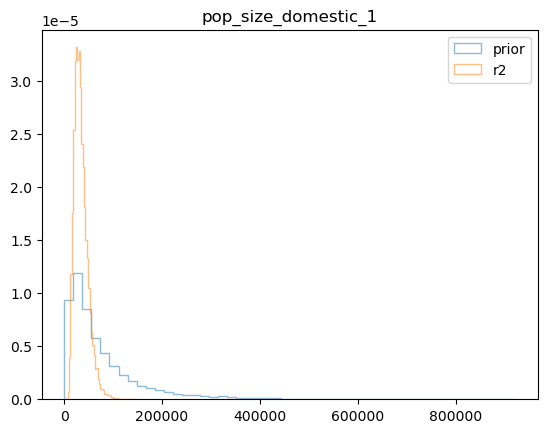

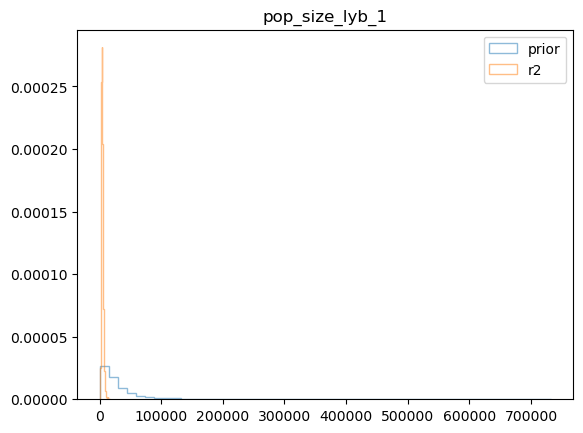

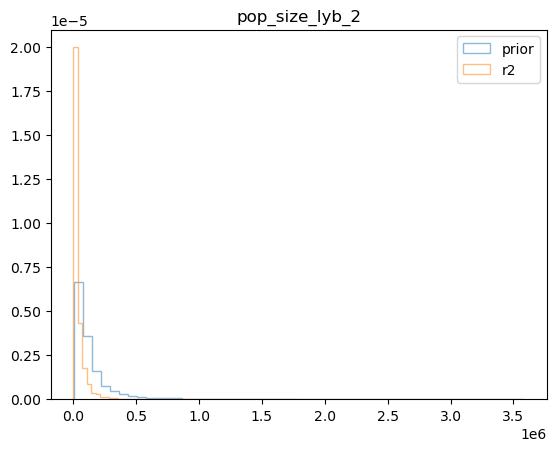

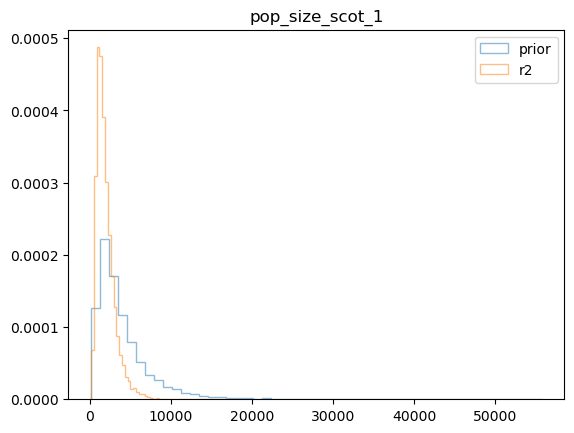

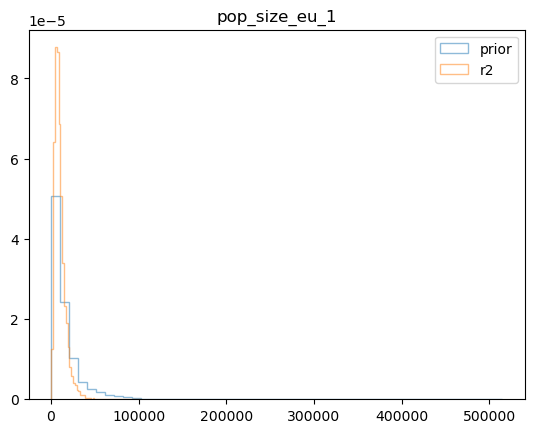

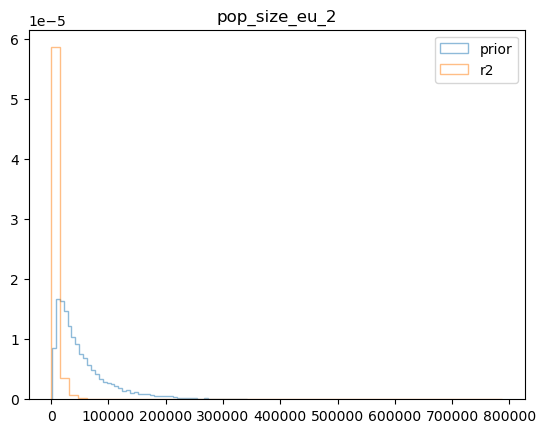

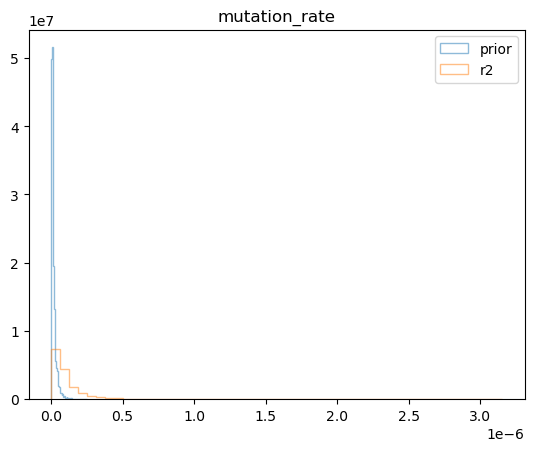

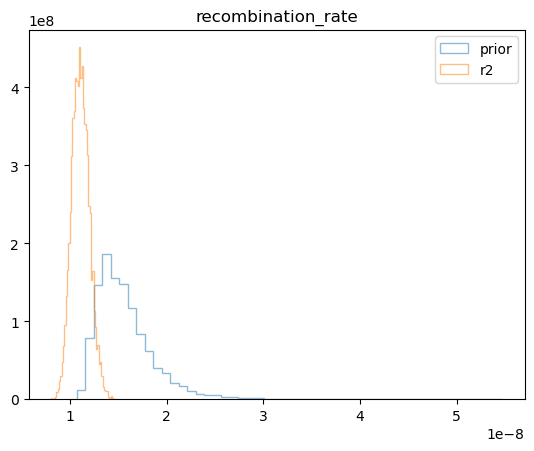

In [25]:
# plot parameter distributions
for num in range(0,16):  
    plt.hist(theta[:,num],
             alpha=0.5,
             label='prior', bins=50, density=True, histtype='step')
    
    plt.hist(theta_2[:,num],
             alpha=0.5,
             label='r2', bins=50, density=True, histtype='step')

    #plt.hist(theta_3[:num],
             #alpha=0.5,
             #label='r3', bins=100, density=True, histtype='step')

    plt.legend(loc='upper right')
    plt.title(names[num])
    #plt.yticks([])
    #plt.xlim([0,0.2])
    #plt.xlim([min(theta_r2_big[0:10000, num]), max(theta_r2_big[0:10000, num])])
    plt.show()